# Code to split the larger dataset into smaller, more appropriate datasets
### Note: please don't run this code as I didn't include the larger dataset file. Skip down to where I start the parsing and concatenaton of the season datasets

### Fetched the following dataset from Kaggle:

https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016?select=NFL+Play+by+Play+2009-2018+%28v5%29.csv

__Below cell is in Raw mode so it doesn't run when you run all the cells__

# Parsing and Concatenation Starts Here
__Let's read in the files and concatenate them into a data frame__

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Season files are stored in the season_datasets folder and they go from 2009-2018
df = pd.concat([pd.read_csv(f"season_datasets/{season}_plays.csv") for season in range(2009, 2019)], ignore_index=True)

/home/ec2-user/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
# Let's confirm we imported properly
len(df)

340080

In [4]:
df.head(5)

,game_id,yardline_100,game_date,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,...,extra_point_attempt,two_point_attempt,field_goal_attempt,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,season
0,2009091000,58.0,2009-09-10,PIT 42,10,5,(14:53) B.Roethlisberger pass short left to H....,pass,5.0,0,...,0.0,0.0,0.0,00-0022924,B.Roethlisberger,00-0017162,H.Ward,NaN,NaN,2009
1,2009091000,53.0,2009-09-10,PIT 47,5,2,(14:16) W.Parker right end to PIT 44 for -3 ya...,run,-3.0,0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,00-0022250,W.Parker,2009
2,2009091000,56.0,2009-09-10,PIT 44,8,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...,pass,0.0,1,...,0.0,0.0,0.0,00-0022924,B.Roethlisberger,00-0026901,M.Wallace,NaN,NaN,2009
3,2009091000,98.0,2009-09-10,TEN 2,10,0,(13:16) C.Johnson up the middle to TEN 2 for n...,run,0.0,0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,00-0026164,C.Johnson,2009
4,2009091000,98.0,2009-09-10,TEN 2,10,4,(12:40) K.Collins pass short left to A.Hall to...,pass,4.0,0,...,0.0,0.0,0.0,00-0003292,K.Collins,00-0024489,A.Hall,NaN,NaN,2009


In [5]:
# Let's check the type of game date as we want to ensure it is a datetime object
df.dtypes['game_date']

dtype('O')

In [6]:
# Convert to a datetime object since it wasn't already
df['game_date'] = pd.to_datetime(df['game_date'])

In [7]:
# Let's double check
df.dtypes['game_date']

dtype('<M8[ns]')

__Now that we have populated the files, let's read them and derive some extra columns we may want for our visualizations__


In [8]:
import numpy as np
import pandas as pd
import re

In [9]:
df['pass_location'].unique()

array(['left', nan, 'right', 'middle'], dtype=object)

__The pass location field doesn't provide the added level of granularity I want for my analysis so let's try parsing the description__

In [10]:
# Let's take a look at the pass plays that have no location
for description in df[(df['play_type'] == 'pass') & (df['pass_location'].isna())].sample(10).desc:
    print(description)

(7:27) (Shotgun) P.Rivers sacked at SD 17 for -3 yards (J.Powe).
*** play under review ***
(4:59) (Shotgun) P.Rivers sacked at SD 24 for -6 yards (R.Pitoitua).
(11:27) (No Huddle, Shotgun) E.Manning sacked at NYG 45 for -5 yards (Z.Kerr). FUMBLES (Z.Kerr), recovered by NYG-J.Walton at NYG 48. J.Walton to NYG 48 for no gain (B.Werner). Officially, a sack for -2 yards.
(:34) K.Cousins sacked at MIN 17 for -3 yards (B.Graham).
(6:22) (Shotgun) G.Smith sacked at NO 21 for 0 yards (D.Hawthorne).
(5:54) P.Rivers pass incomplete to A.Gates [A.Davis].
(:43) (Shotgun) R.Wilson sacked at SEA 25 for -15 yards (O.Pierre). FUMBLES (O.Pierre) [O.Pierre], recovered by SEA-J.Britt at SEA 23. J.Britt to SEA 23 for no gain (O.Pierre).
(5:16) (Shotgun) E.Manning sacked at NYG 10 for -7 yards (K.Correa). FUMBLES (K.Correa) [K.Correa], RECOVERED by TEN-J.Casey at NYG 15. J.Casey to NYG 14 for 1 yard (J.Brown). Officially, a sack for -2 yards.
(3:27) (Shotgun) C.Kaepernick sacked at CHI 48 for -5 yards (W.Y

__There are some that are passes with no location. But most of these look like sacks. So we can remove them from our analysis for now__

In [11]:
# Let's just check the number of each of the pass locations so we feel more comfortable filtering out.
print("Number of pass plays for each pass location")
print("="*50)
print("No Location: ", len(df[(df['play_type'] == 'pass') & (df['pass_location'].isna())]))
for location in ['left', 'right', 'middle']:
    print(f"{location}: ", len(df[(df['play_type'] == 'pass') & (df['pass_location'] == location)]))

Number of pass plays for each pass location
No Location:  12818
left:  62909
right:  70110
middle:  40840


In [12]:
# Let's see some sample description for each of the passing locations
for location in ['left', 'right', 'middle']:
    print("="*40, location, "="*40)
    for description in df[(df['play_type'] == 'pass') & (df['pass_location'] == location)].sample(5).desc:
        print(description)

======================================== left ========================================
(7:13) (Shotgun) D.Brees pass short left to D.Henderson to NO 35 for 4 yards (A.Allen).
(4:04) (Shotgun) A.Luck pass short left to D.Moncrief to WAS 41 for 7 yards (K.Robinson).
(2:00) (Shotgun) M.Moore pass short left to J.Thomas pushed ob at MIA 25 for 12 yards (P.Chung).
(4:46) (Shotgun) R.Fitzpatrick pass short left to B.Marshall for 14 yards, TOUCHDOWN.
(3:04) (Shotgun) D.Kizer pass incomplete short left to B.Treggs [E.Griffen].
======================================== right ========================================
(3:54) (Shotgun) J.Freeman pass short right to T.Underwood to ATL 4 for 10 yards (S.Weatherspoon).
(12:04) (No Huddle, Shotgun) D.Anderson pass short right to L.Stephens-Howling ran ob at ARI 41 for 8 yards.
(14:23) (Shotgun) A.Luck pass short right to D.Brown to IND 18 for 11 yards (C.Finnegan; K.Langford).
(:13) (Shotgun) J.Winston pass short right to C.Sims to TB 10 for 4 yards. La

In [13]:
# Let's see if we can properly parse enough of the rows to get enough data for our analysis
df['pass_loc_detailed'] = df[df['play_type'] == 'pass']['desc'].str.extract(r"pass (?:incomplete )?([A-Za-z\s]+?)\.? (?:to|intended|intercepted)", flags=re.IGNORECASE)

In [14]:
# Let's see what we got!
df['pass_loc_detailed'].value_counts()

short right              56622
short left               50554
short middle             32976
deep right               12439
deep left                11969
deep middle               7699
incomplete                 103
right                       17
left                        16
middle                      12
short left end               3
was                          2
short right end              2
was thrown incomplete        1
Name: pass_loc_detailed, dtype: int64

__Since we want the extra granularity, let's just keep the first 6 listed above.__  
__Should be okay since the ones we are filtering out make up an extremely tiny portion of the data.__


In [15]:
# Let's just ensure that we can get the top 6 locations without having to hardcode based on the data
# We could also consider doing this by a percentage threshold but this is probably fine for now.
valid_locations = df['pass_loc_detailed'].value_counts().index[0:6]

In [16]:
valid_locations

Index(['short right', 'short left', 'short middle', 'deep right', 'deep left',
       'deep middle'],
      dtype='object')

In [17]:
df.loc[(df['play_type'] == 'pass') & ~(df['pass_loc_detailed'].isin(valid_locations)), 'pass_loc_detailed'] = np.nan

In [18]:
# Let's see what we got after we filtered out a bit
df['pass_loc_detailed'].value_counts()

short right     56622
short left      50554
short middle    32976
deep right      12439
deep left       11969
deep middle      7699
Name: pass_loc_detailed, dtype: int64

__Let's dig into some visuals with these passing locations__

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep

In [20]:
pass_locations_by_season = df[~df['pass_loc_detailed'].isna()].groupby(['season', 'pass_loc_detailed']).size().to_frame("num_plays")

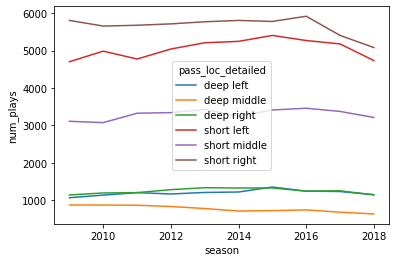

In [21]:
sns.lineplot(data=pass_locations_by_season.reset_index(), x='season', y='num_plays', hue='pass_loc_detailed');

__Let's create a heatmap of the pass distribution year by year. We probably won't see drastic differences, but it'll be interesting to see the subtle differences.__

In [22]:
def getHeatMapDataForSeason(season):
    passes_by_season = pass_locations_by_season.loc[season].reset_index().copy()
    passes_by_season['depth'] = passes_by_season['pass_loc_detailed'].str.extract(r"^(\w+)")
    passes_by_season['side'] = passes_by_season['pass_loc_detailed'].str.extract(r"(\w+)$")
    passes_by_season.drop(columns="pass_loc_detailed", inplace=True)
    return passes_by_season

In [23]:
# Let's increase the font size in our plots
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

<IPython.core.display.Javascript object>


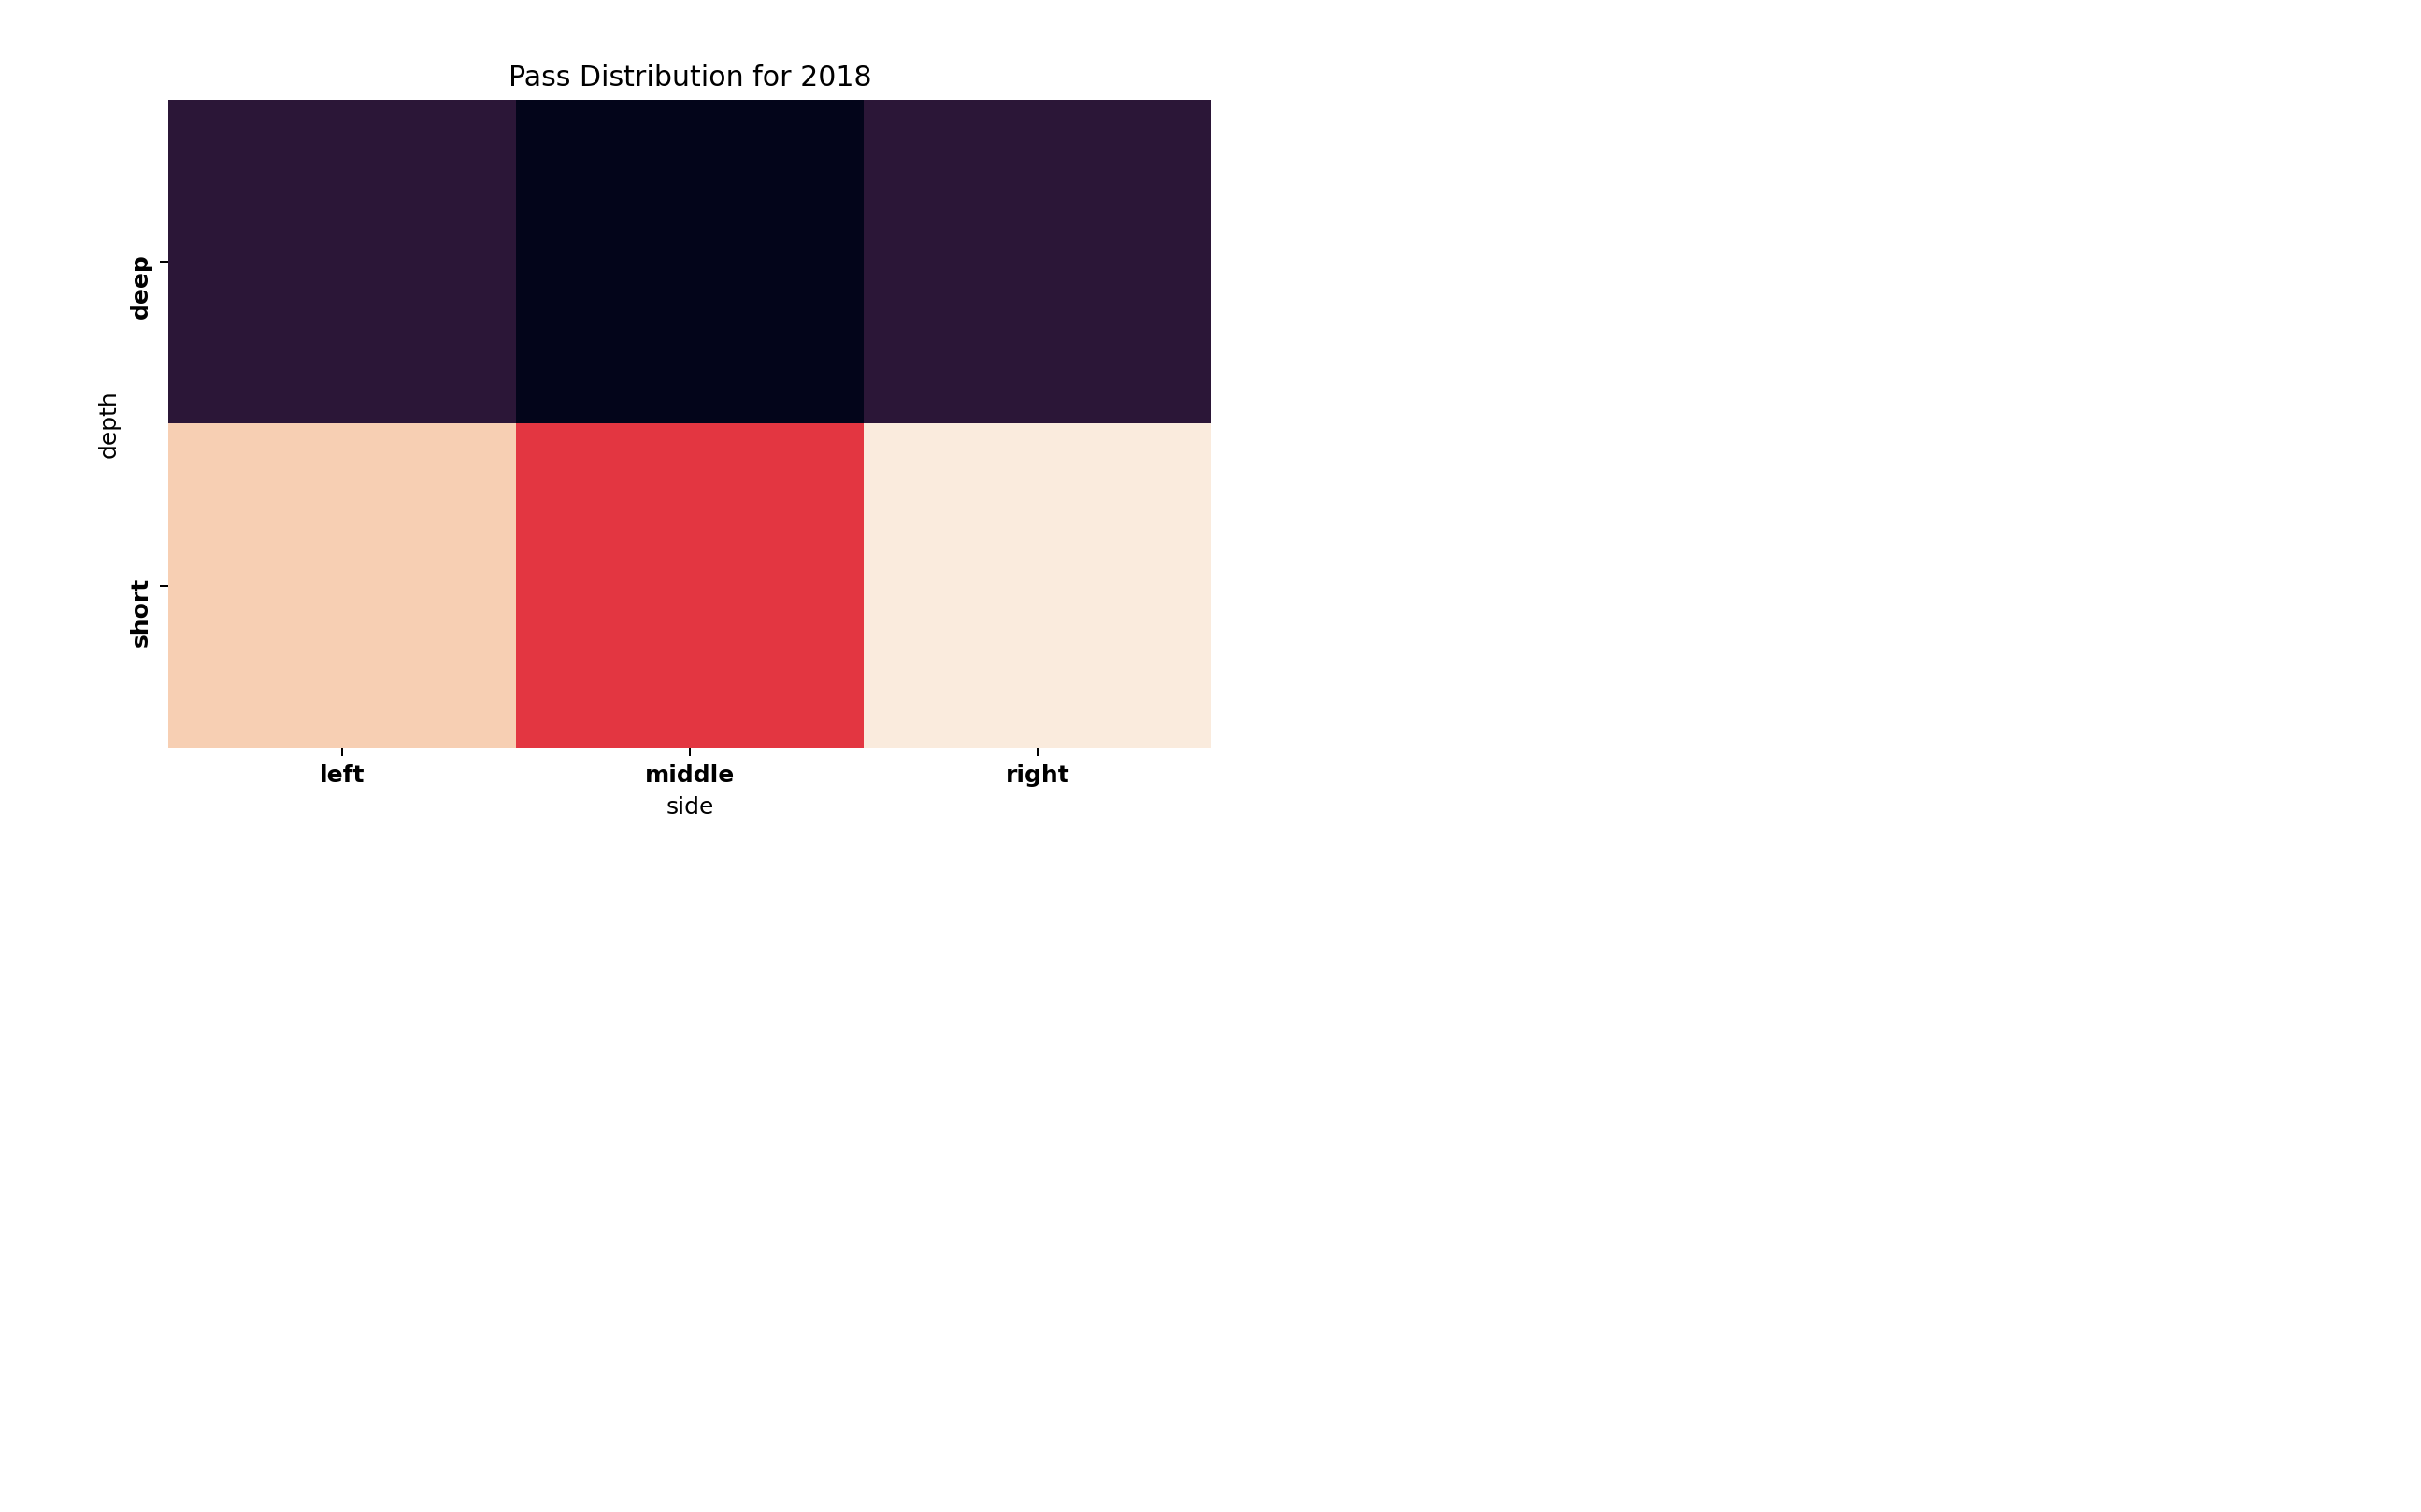

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [24]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,5))
for season in range(2009, 2019):
    passes_by_season = getHeatMapDataForSeason(season)

    sns.heatmap(passes_by_season.pivot("depth", "side", "num_plays"), ax = ax, cbar=False)
    ax.set_title(f"Pass Distribution for {season}")
    fig.canvas.draw()
    sleep(0.5)

__Now, let's spit out all the heatmaps for use later__

<IPython.core.display.Javascript object>


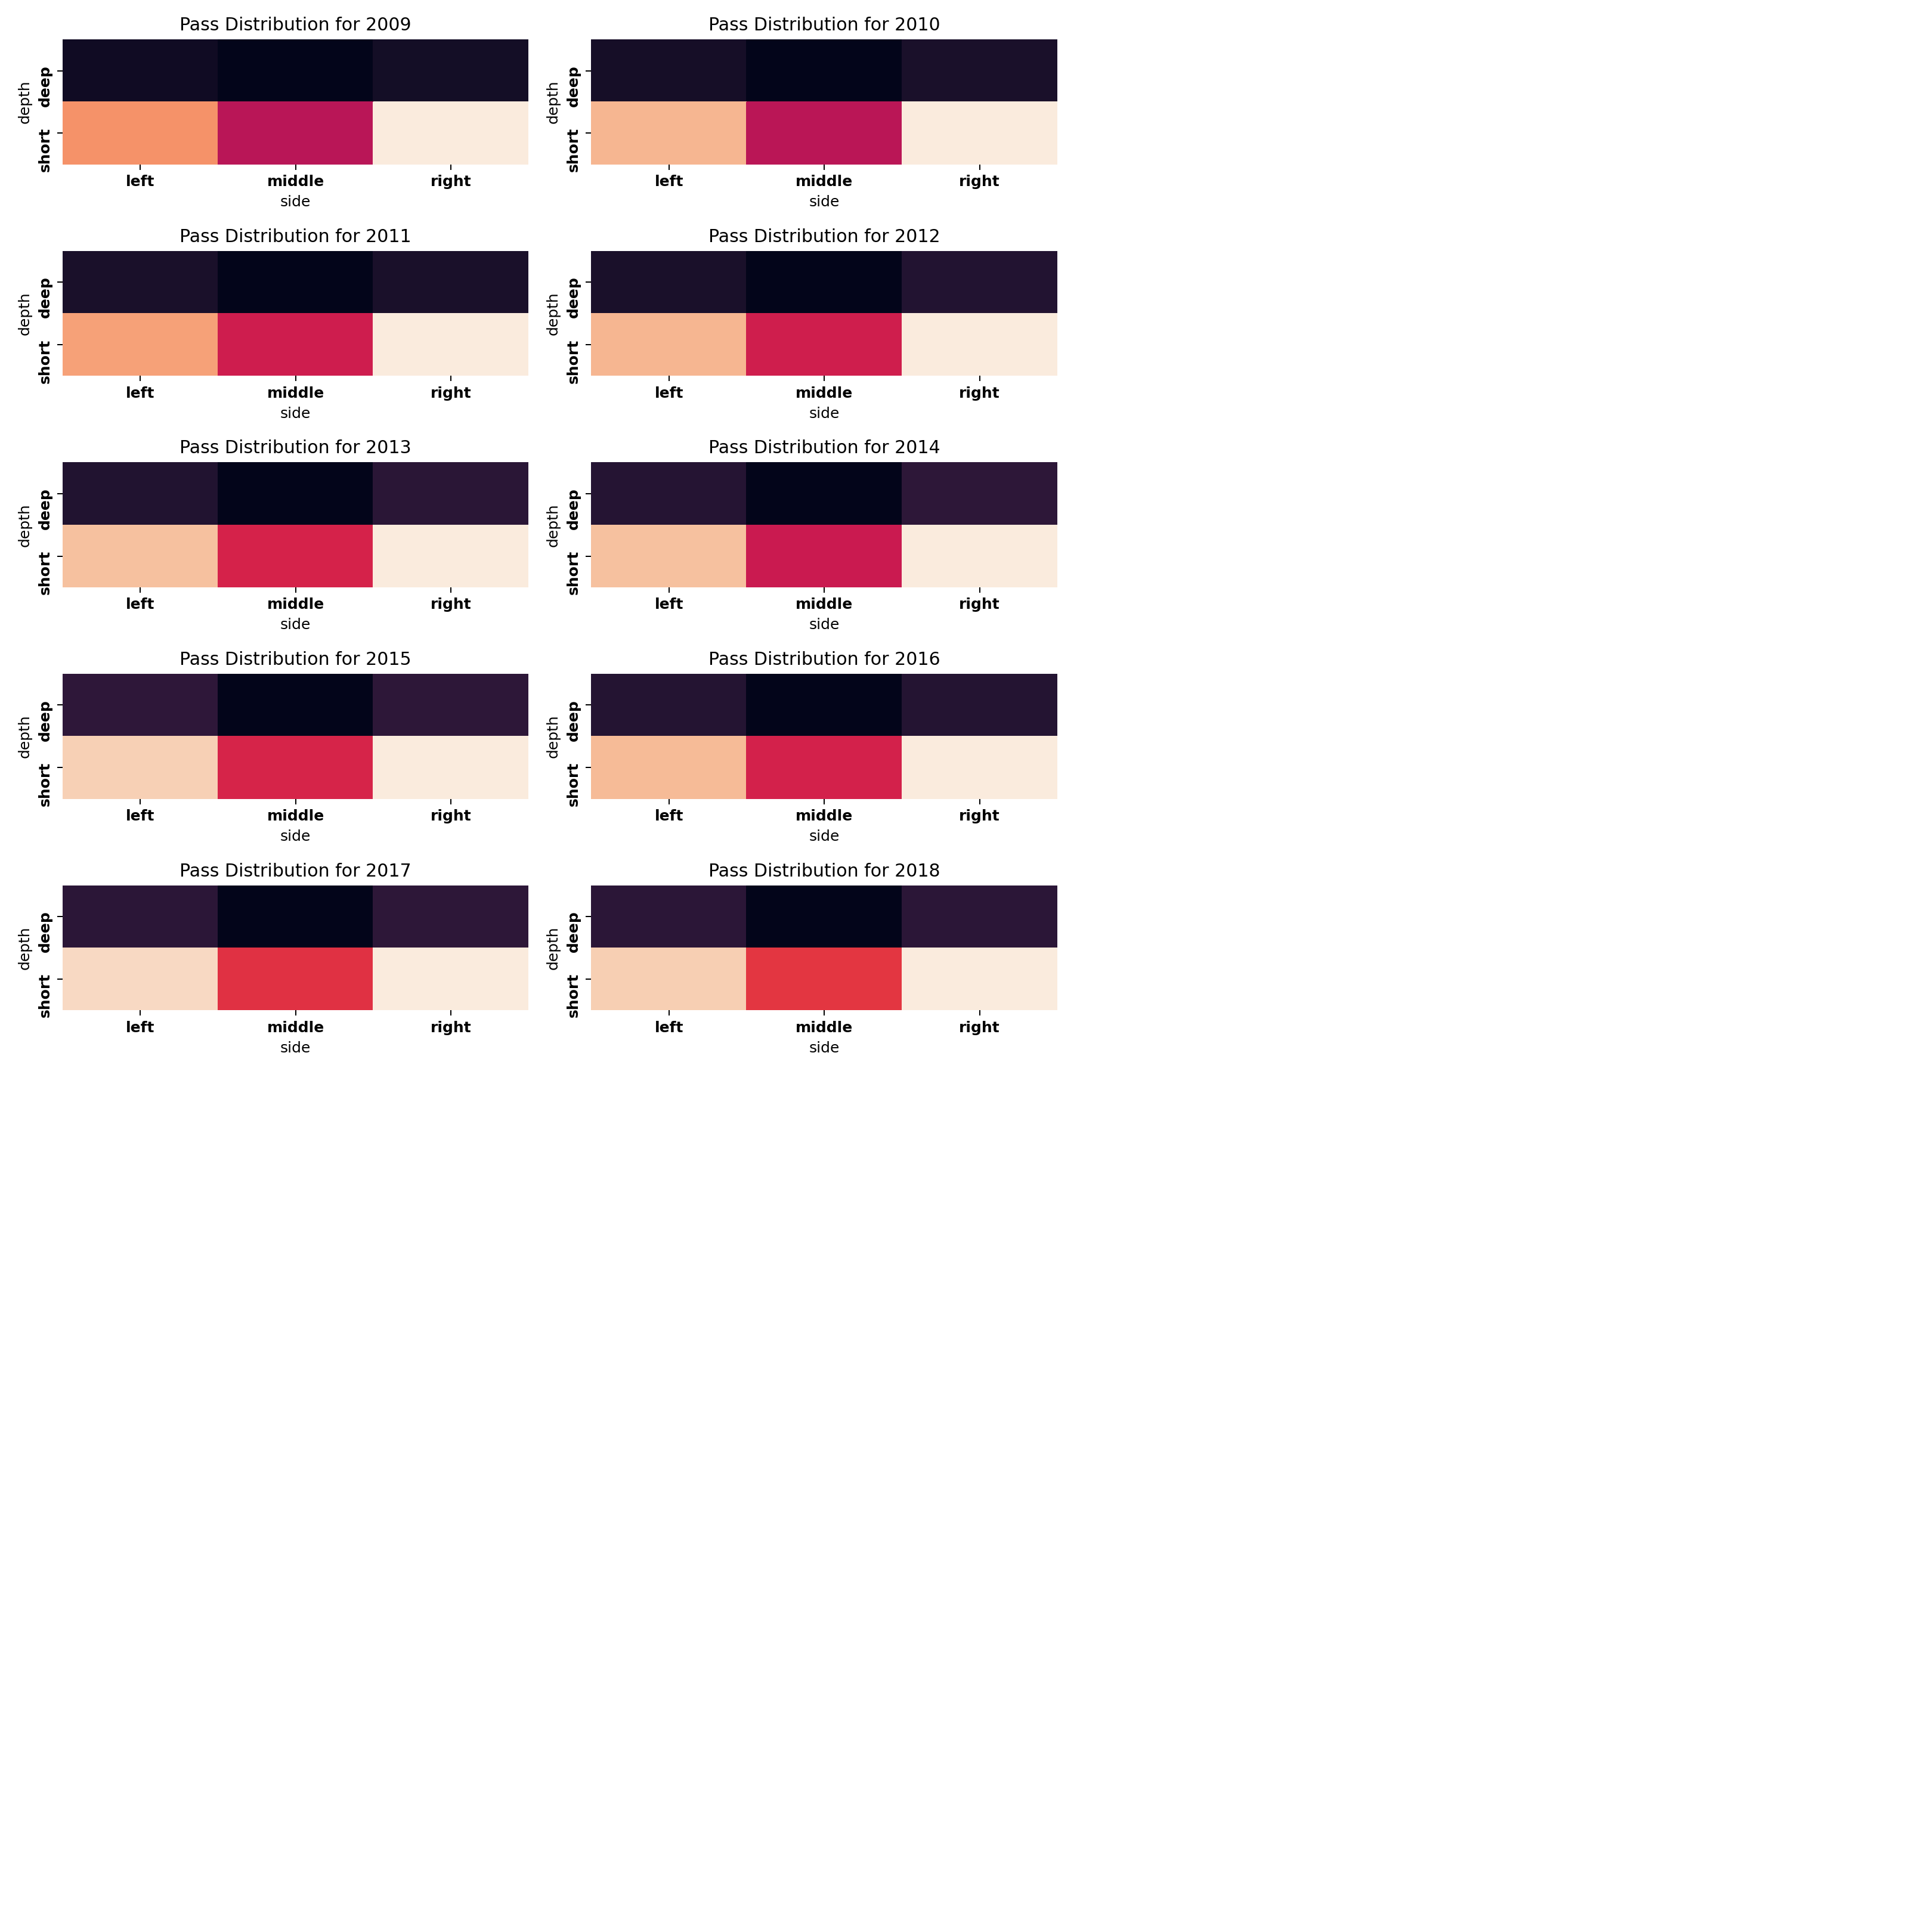

In [28]:
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
plot_num = 0
for season in range(2009, 2019):
    passes_by_season = getHeatMapDataForSeason(season)
    row = plot_num//2
    col = plot_num%2
    sns.heatmap(passes_by_season.pivot("depth", "side", "num_plays"), ax = ax[row][col], cbar=False)
    ax[row][col].set_title(f"Pass Distribution for {season}")
    plot_num += 1
    plt.show()
fig.tight_layout()

__For fun, let's inspect the field goal and extra point success over the years.__

In [29]:
# Let's first see the possible values for the extra point.
df.loc[df['play_type'] == 'extra_point', 'extra_point_result'].unique()

array(['good', 'failed', 'blocked', 'aborted'], dtype=object)

__We only want to consider plays where the kicker actually kicked the ball. So we can filter out "aborted"__

In [30]:
# Let's swap aborted to NaN
df['extra_point_result'] = df['extra_point_result'].replace(to_replace="aborted", value=np.nan)

In [31]:
# Let's double check that we only have 3 non-NaN results
df.loc[df['play_type'] == 'extra_point', 'extra_point_result'].unique()

array(['good', 'failed', 'blocked', nan], dtype=object)

In [32]:
# Let's just rename to Made or Missed for ease
df['extra_point_result'] = df['extra_point_result'].replace(to_replace=["good", "failed", "blocked"], value=["Made", "Missed", "Missed"])

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
xp_kicks_by_season = df[df['extra_point_result'] == 'Made'].groupby(['season']).agg({'extra_point_result': 'count'}).div(df[~df['extra_point_result'].isna()].groupby(['season']).agg({'extra_point_result': 'count'})).rename(columns={"extra_point_result": "XP Pct"})

<IPython.core.display.Javascript object>


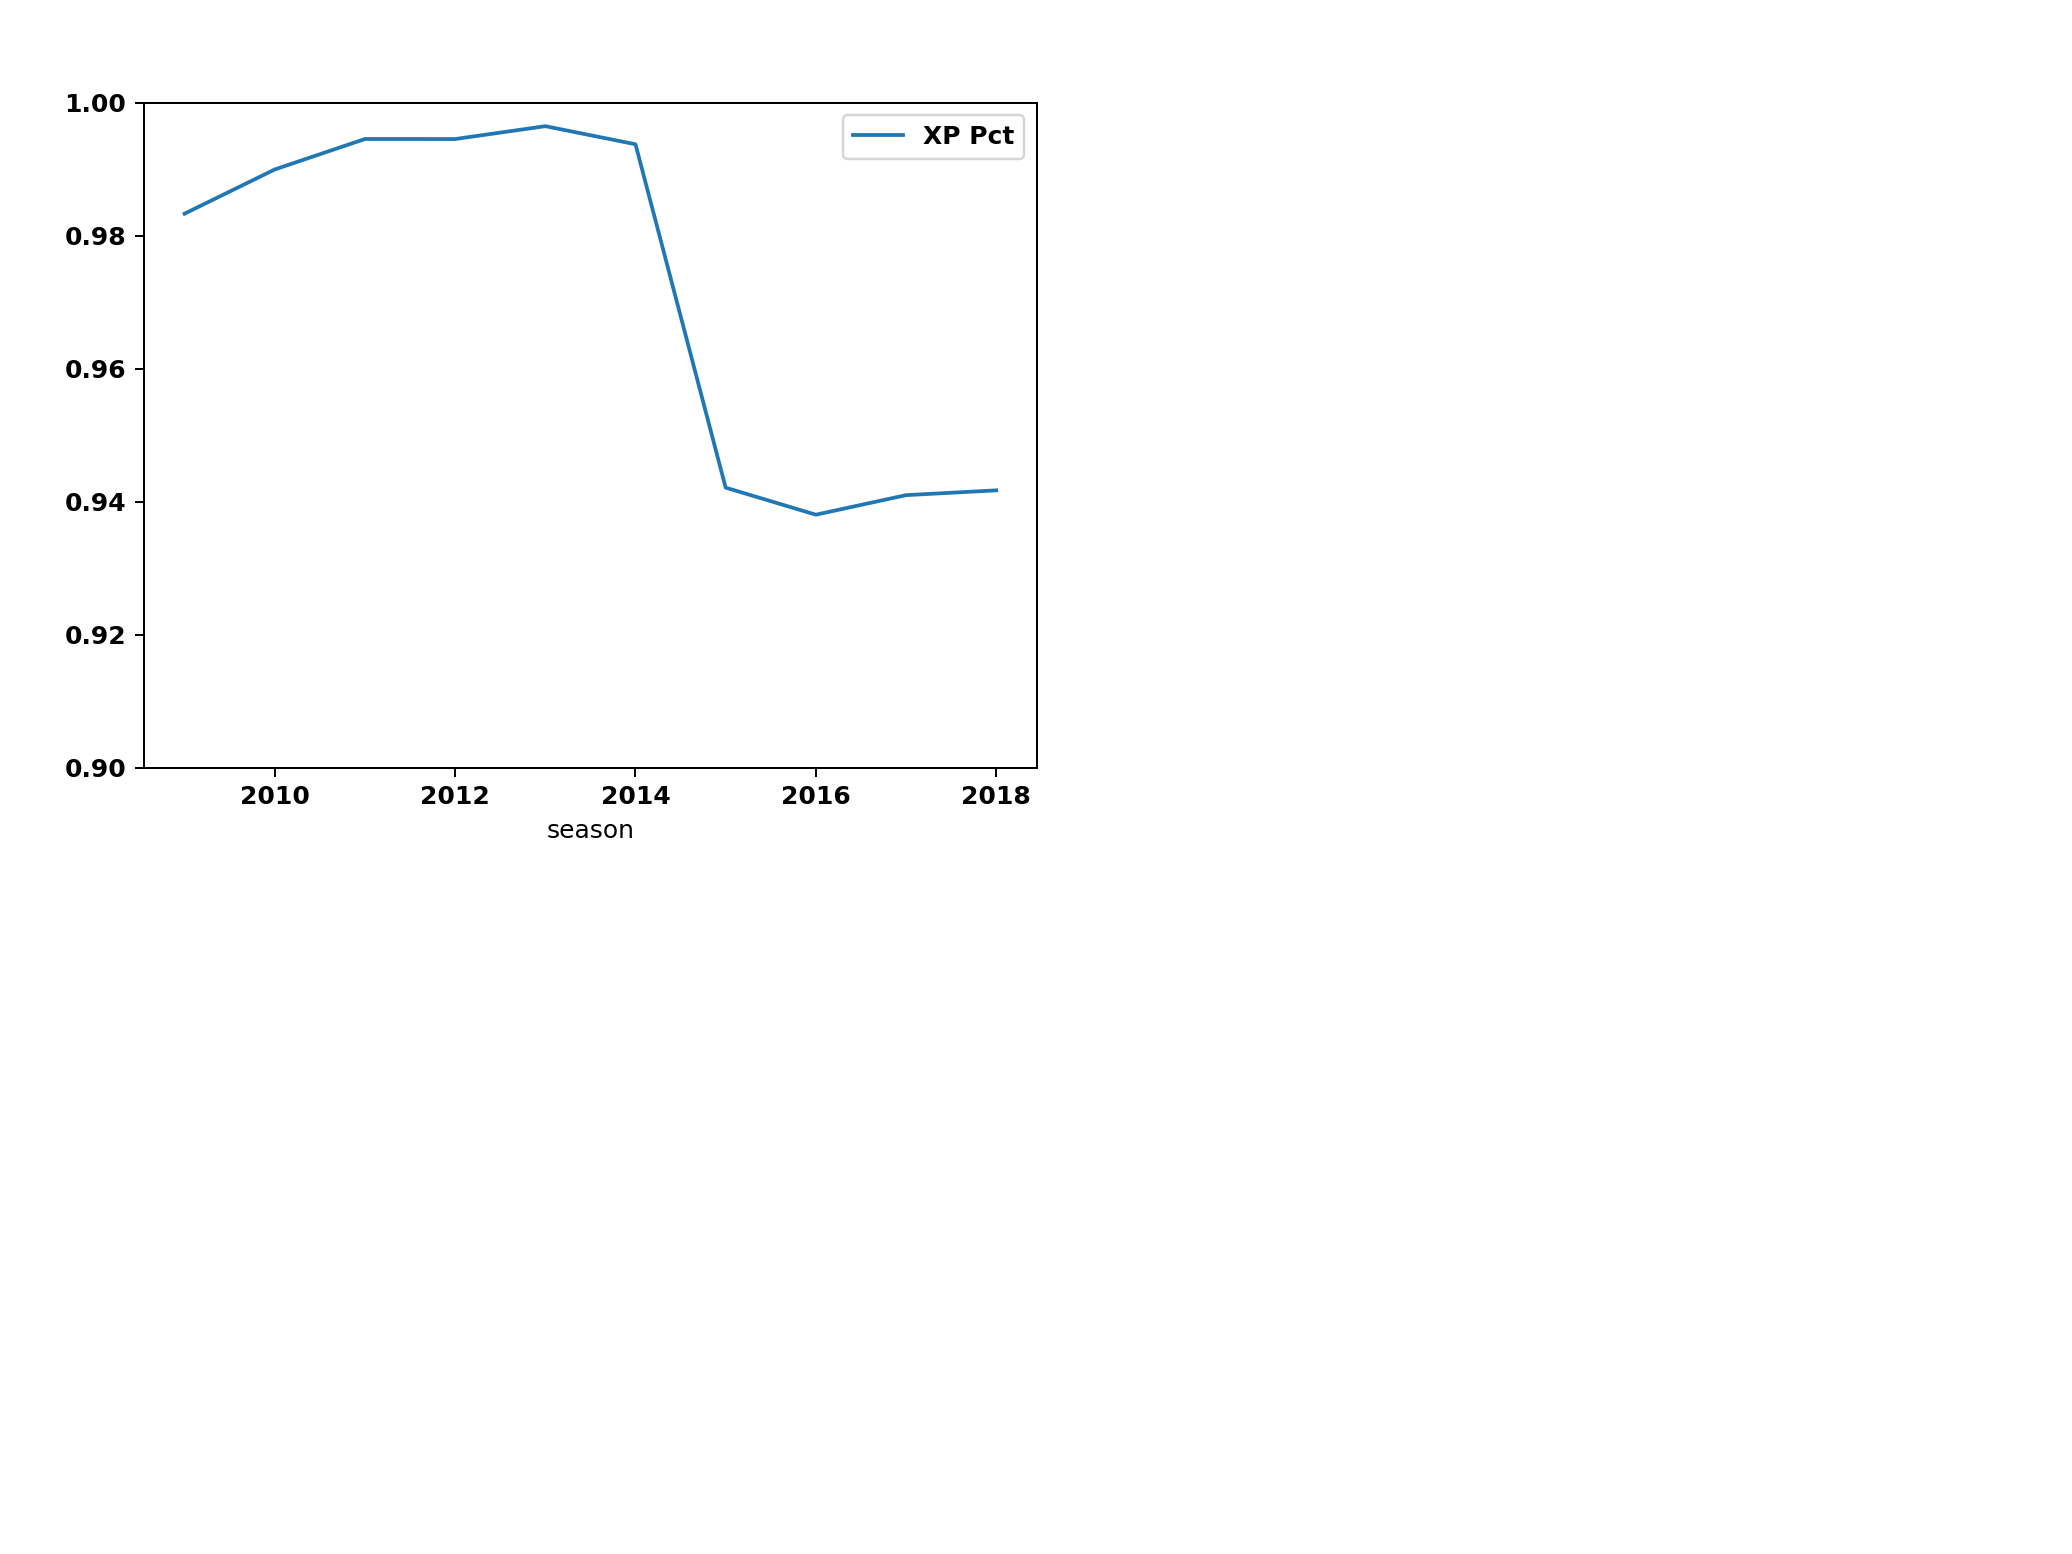

In [35]:
ax = sns.lineplot(data=xp_kicks_by_season);
ax.set(ylim=(.9, 1));
plt.show()

__NOW, field goal time!!!__

In [36]:
# Let's first see the possible values for the field goal
df.loc[df['play_type'] == 'field_goal', 'field_goal_result'].unique()

array(['missed', 'blocked', 'made'], dtype=object)

In [37]:
# Let's just classify a block as a miss
df['field_goal_result'] = df['field_goal_result'].replace(to_replace="blocked", value="missed")

In [38]:
# Let's verify it changed
df.loc[df['play_type'] == 'field_goal', 'field_goal_result'].unique()

array(['missed', 'made'], dtype=object)

In [39]:
# Now, let's check if we have any NaN for kick distance
len(df[(df['play_type'] == 'field_goal') & (df['kick_distance'].isna())])

8

In [40]:
# Since a small number, let's just use the yard line and add 18 to get the kick distance.
df.loc[(df['play_type'] == 'field_goal') & (df['kick_distance'].isna()), 'kick_distance'] = df[(df['play_type'] == 'field_goal') & (df['kick_distance'].isna())]['yardline_100'] + 18

In [41]:
# Let's double check it worked
len(df[(df['play_type'] == 'field_goal') & (df['kick_distance'].isna())])

0

In [42]:
def convertKickDistanceToFgRange(distance):
    rangeBegin = int(10*(distance//10))
    return f"{rangeBegin}-{rangeBegin+9}"

In [43]:
df['fg_range'] = df[df['play_type'] == 'field_goal']['kick_distance'].map(convertKickDistanceToFgRange, na_action='ignore')

In [44]:
# Let's check if it spit out what we expected
df['fg_range'].unique()

array([nan, '30-39', '40-49', '20-29', '50-59', '60-69', '10-19', '70-79'],
      dtype=object)

In [45]:
fg_kicks_by_season = df[~df['fg_range'].isna()].groupby(['season', 'fg_range']).size().to_frame("num_kicks")

<IPython.core.display.Javascript object>


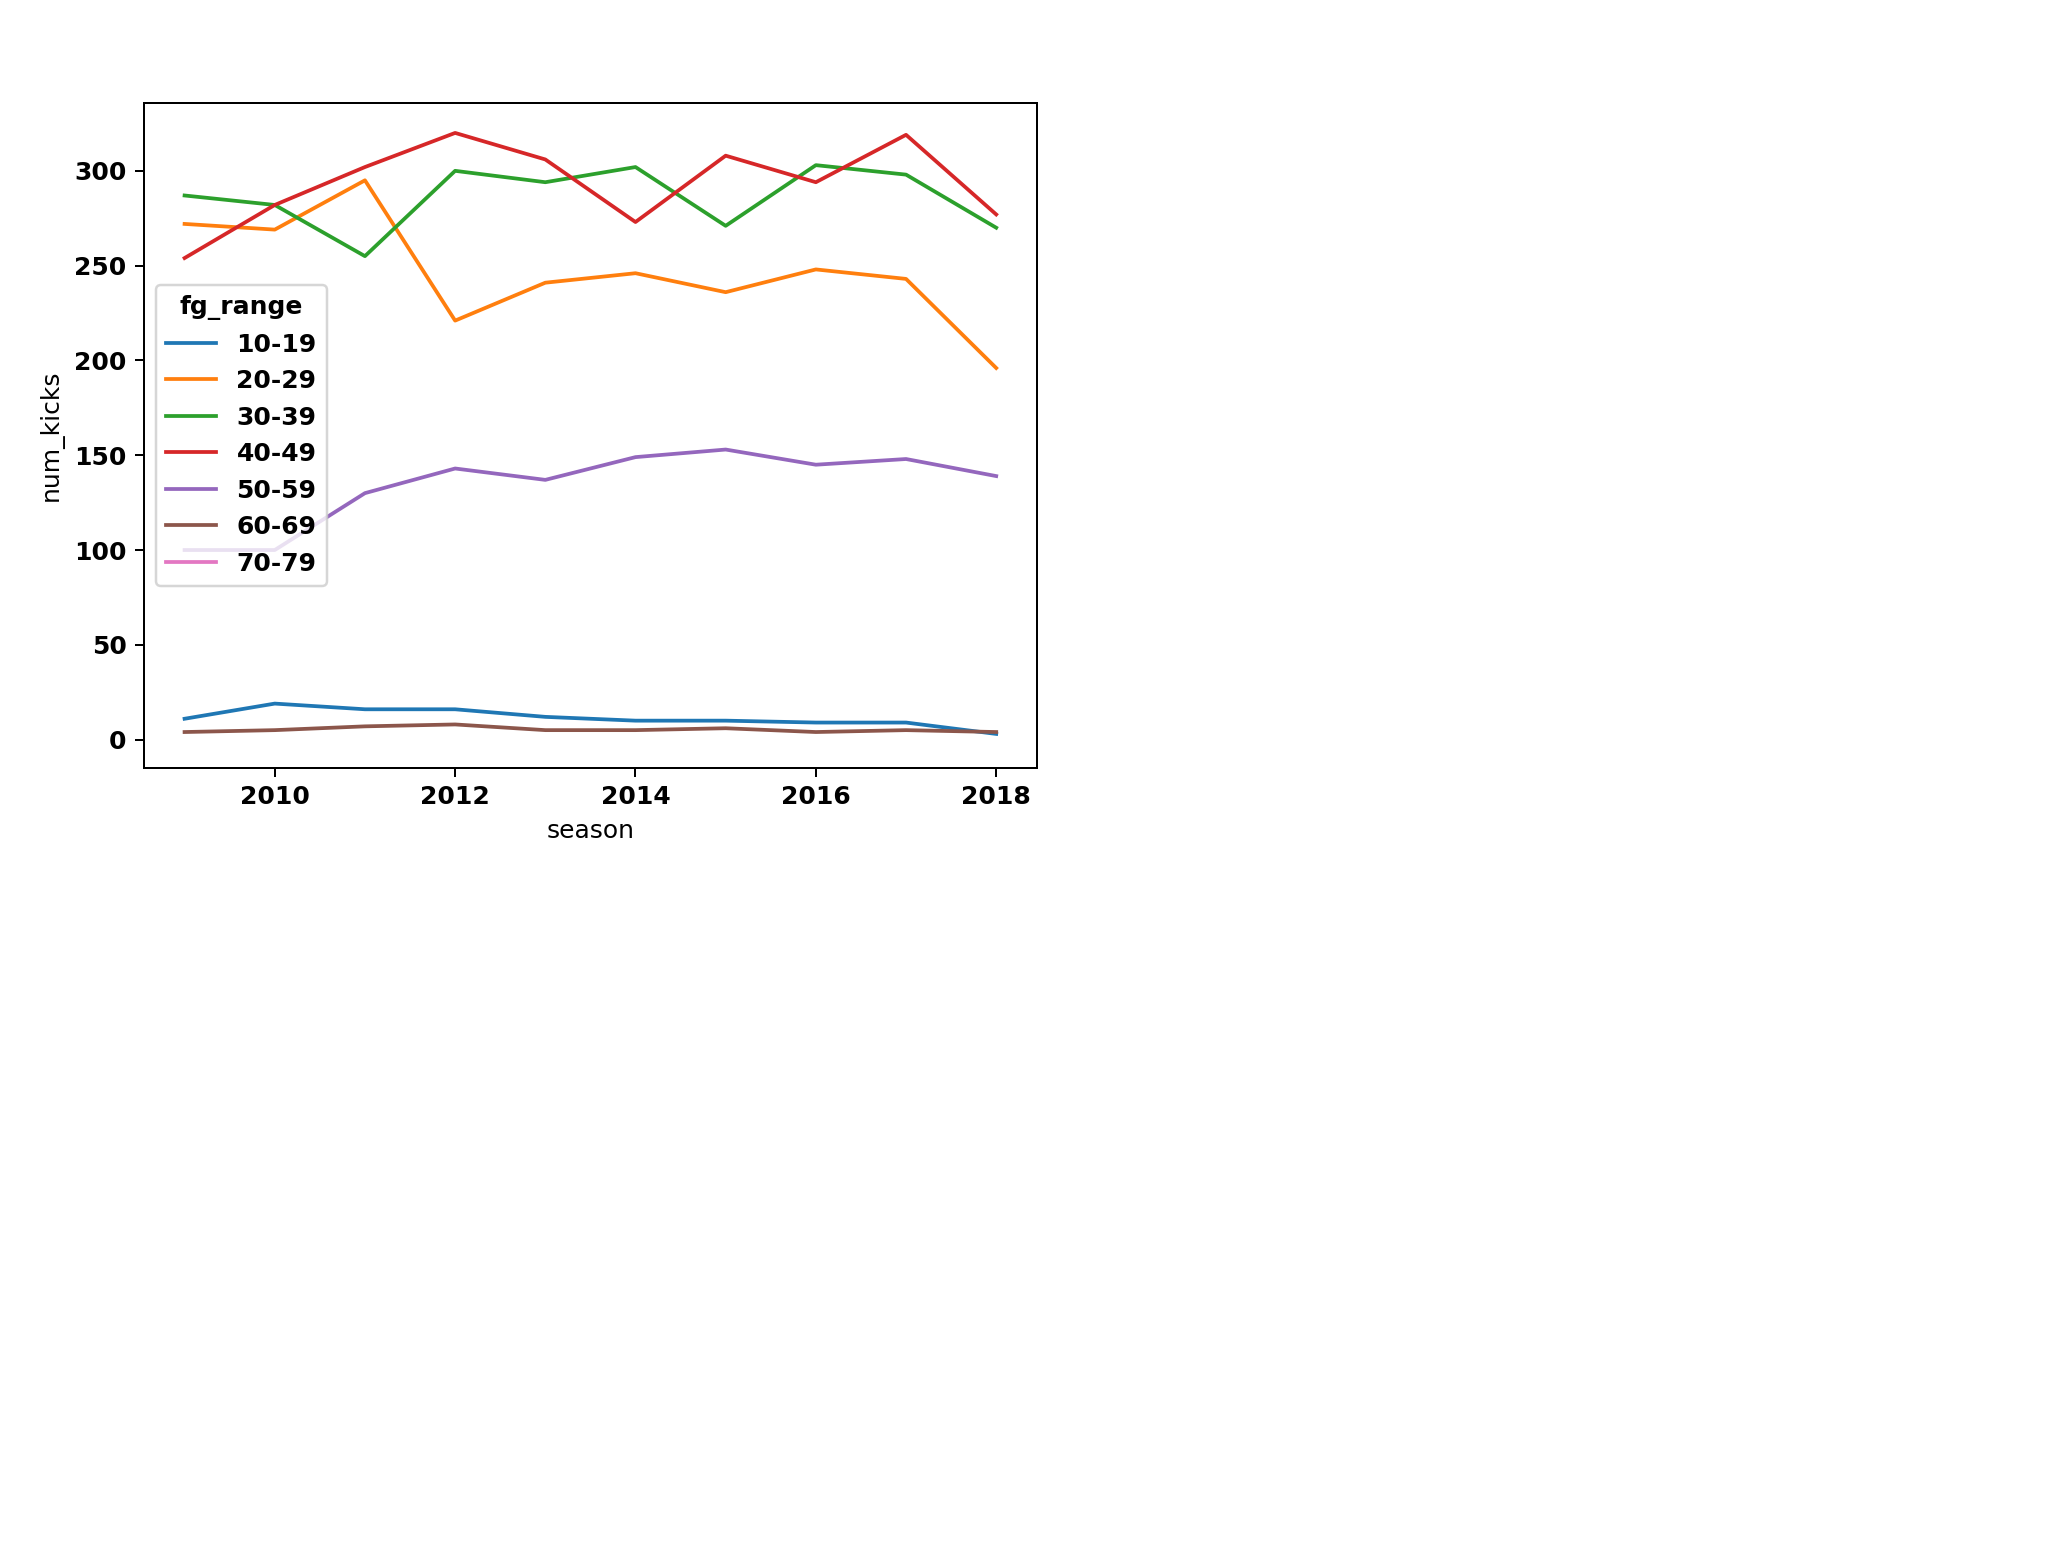

In [46]:
sns.lineplot(data=fg_kicks_by_season.reset_index(), x='season', y='num_kicks', hue='fg_range');
plt.show()

In [47]:
pct_fg_by_season = df[df['field_goal_result'] == 'made'].groupby(['season', 'fg_range']).agg({'field_goal_result': 'count'}).div(df[~df['field_goal_result'].isna()].groupby(['season', 'fg_range']).agg({'field_goal_result': 'count'})).rename(columns={"field_goal_result": "FG Pct"})

<IPython.core.display.Javascript object>


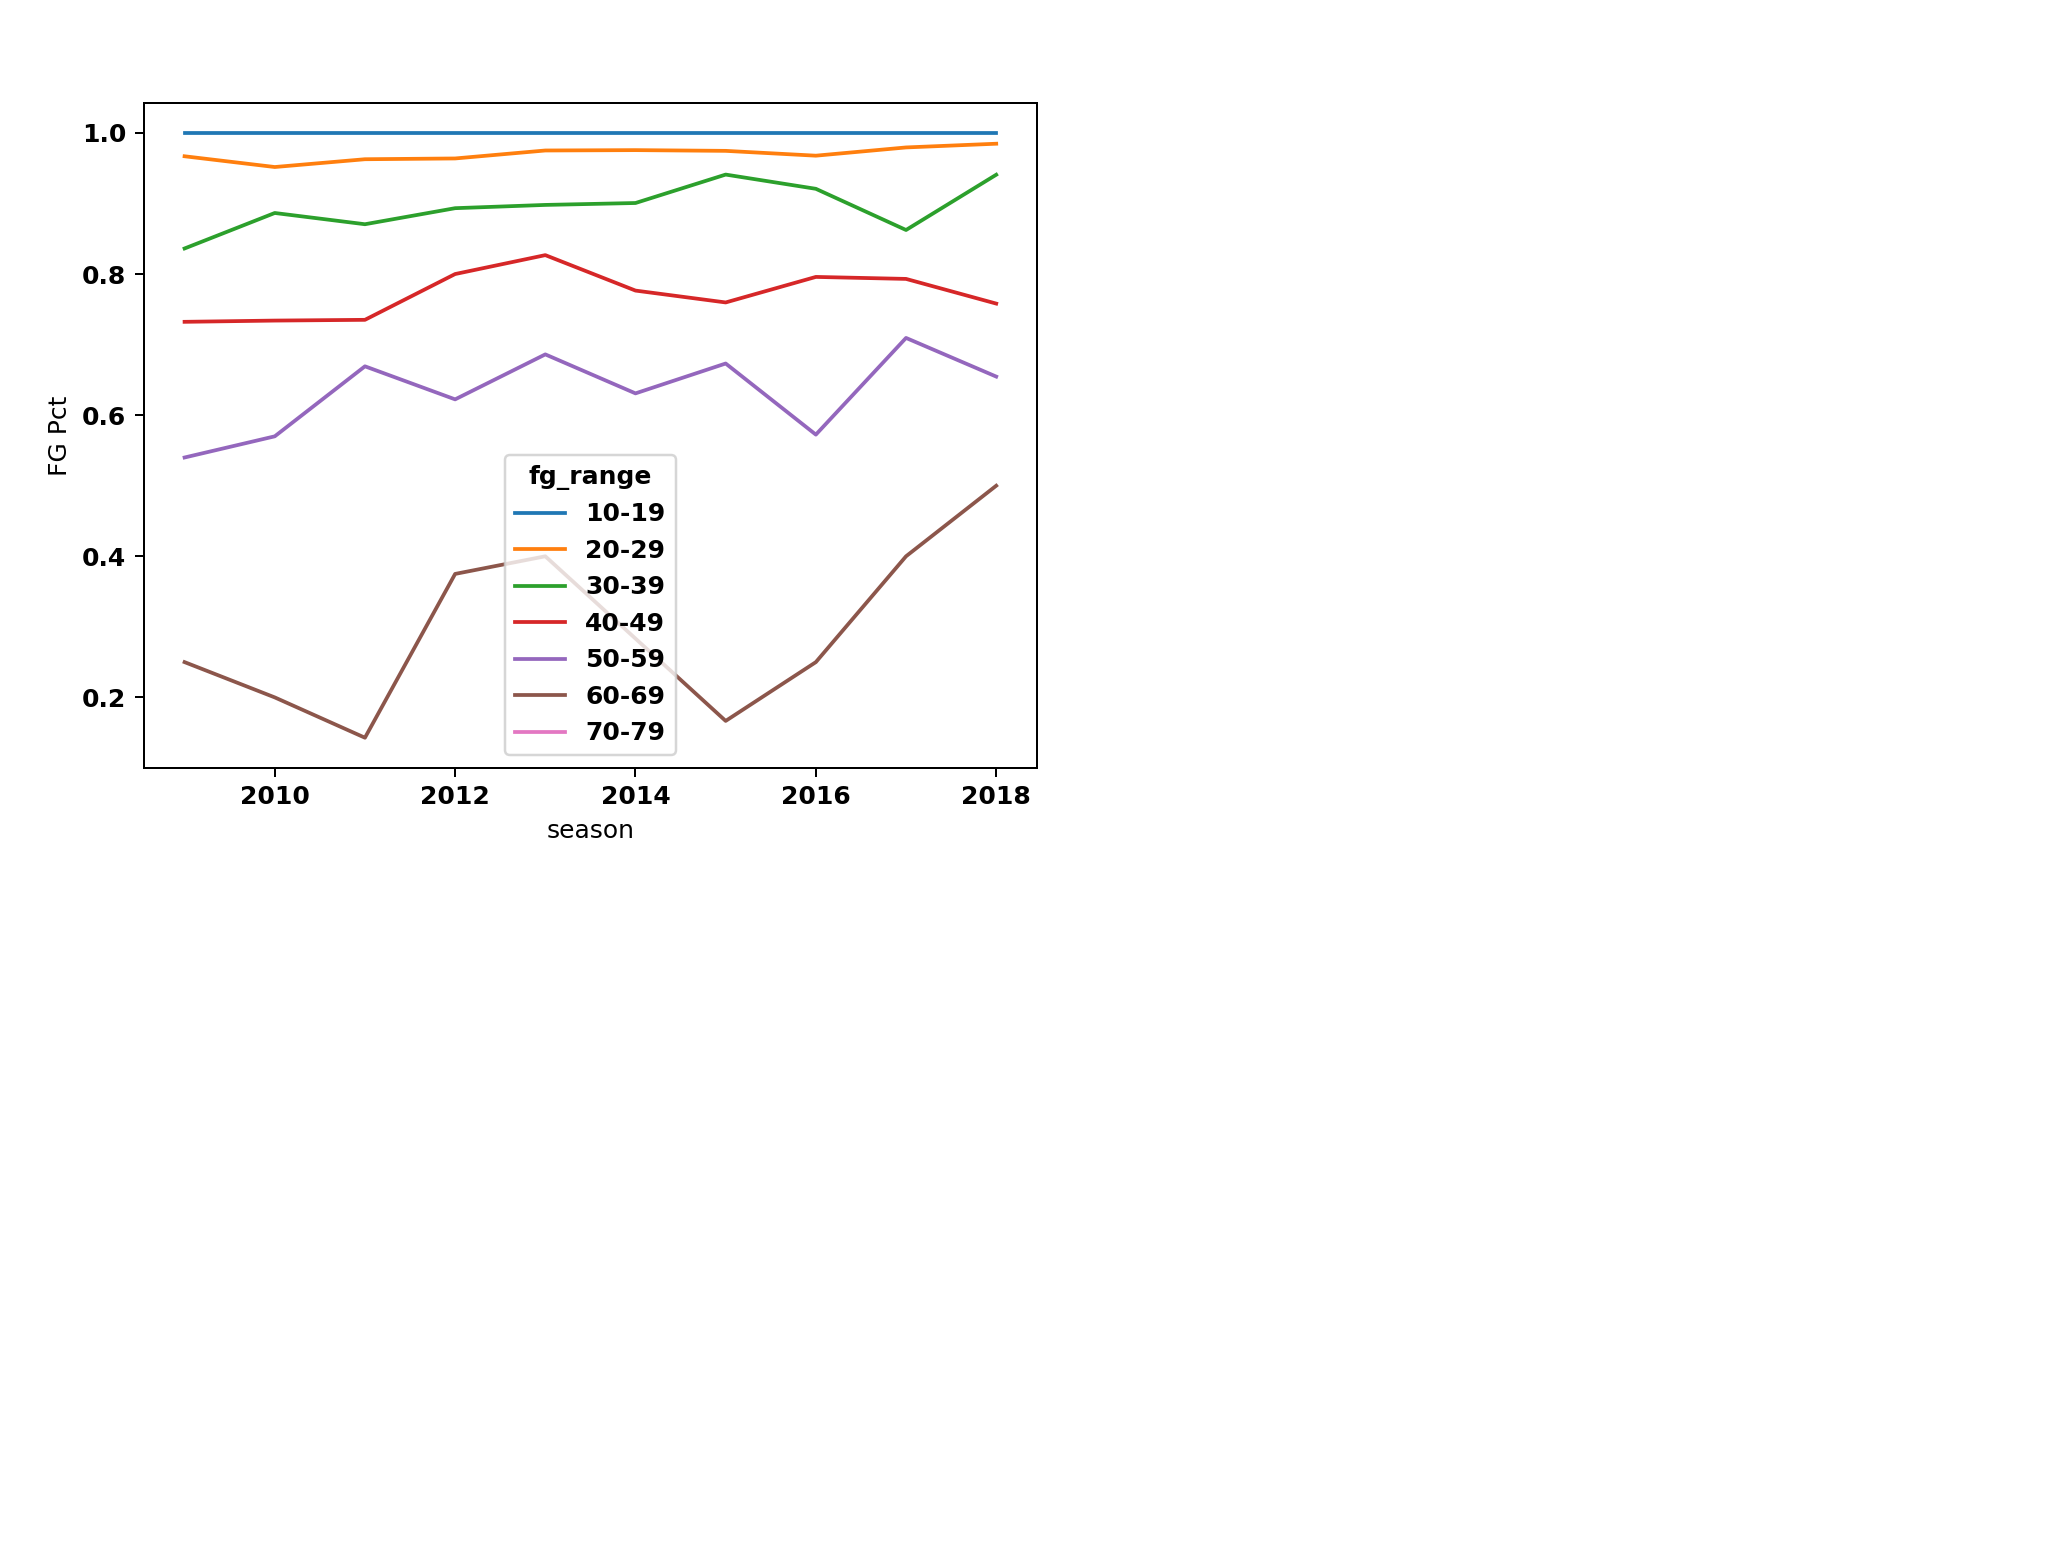

In [49]:
sns.lineplot(data=pct_fg_by_season.reset_index(), x='season', y='FG Pct', hue='fg_range')
plt.show()

In [50]:
# Convert to a datetime object since it wasn't already
df['game_date'] = pd.to_datetime(df['game_date'])

In [51]:
df['game_month'] = df['game_date'].dt.month_name()

In [52]:
df.game_month.unique()

array(['September', 'October', 'November', 'December', 'January'],
      dtype=object)

In [53]:
play_types_by_month = df[df['play_type'].isin(['pass', 'run'])].groupby(['game_month', 'play_type']).size().to_frame("num_plays")

In [54]:
play_types_by_month

num_plays
game_month play_type           
December   pass           47974
           run            35383
January    pass            5794
           run             4258
November   pass           46420
           run            32998
October    pass           46457
           run            32503
September  pass           40032
           run            27550

<IPython.core.display.Javascript object>


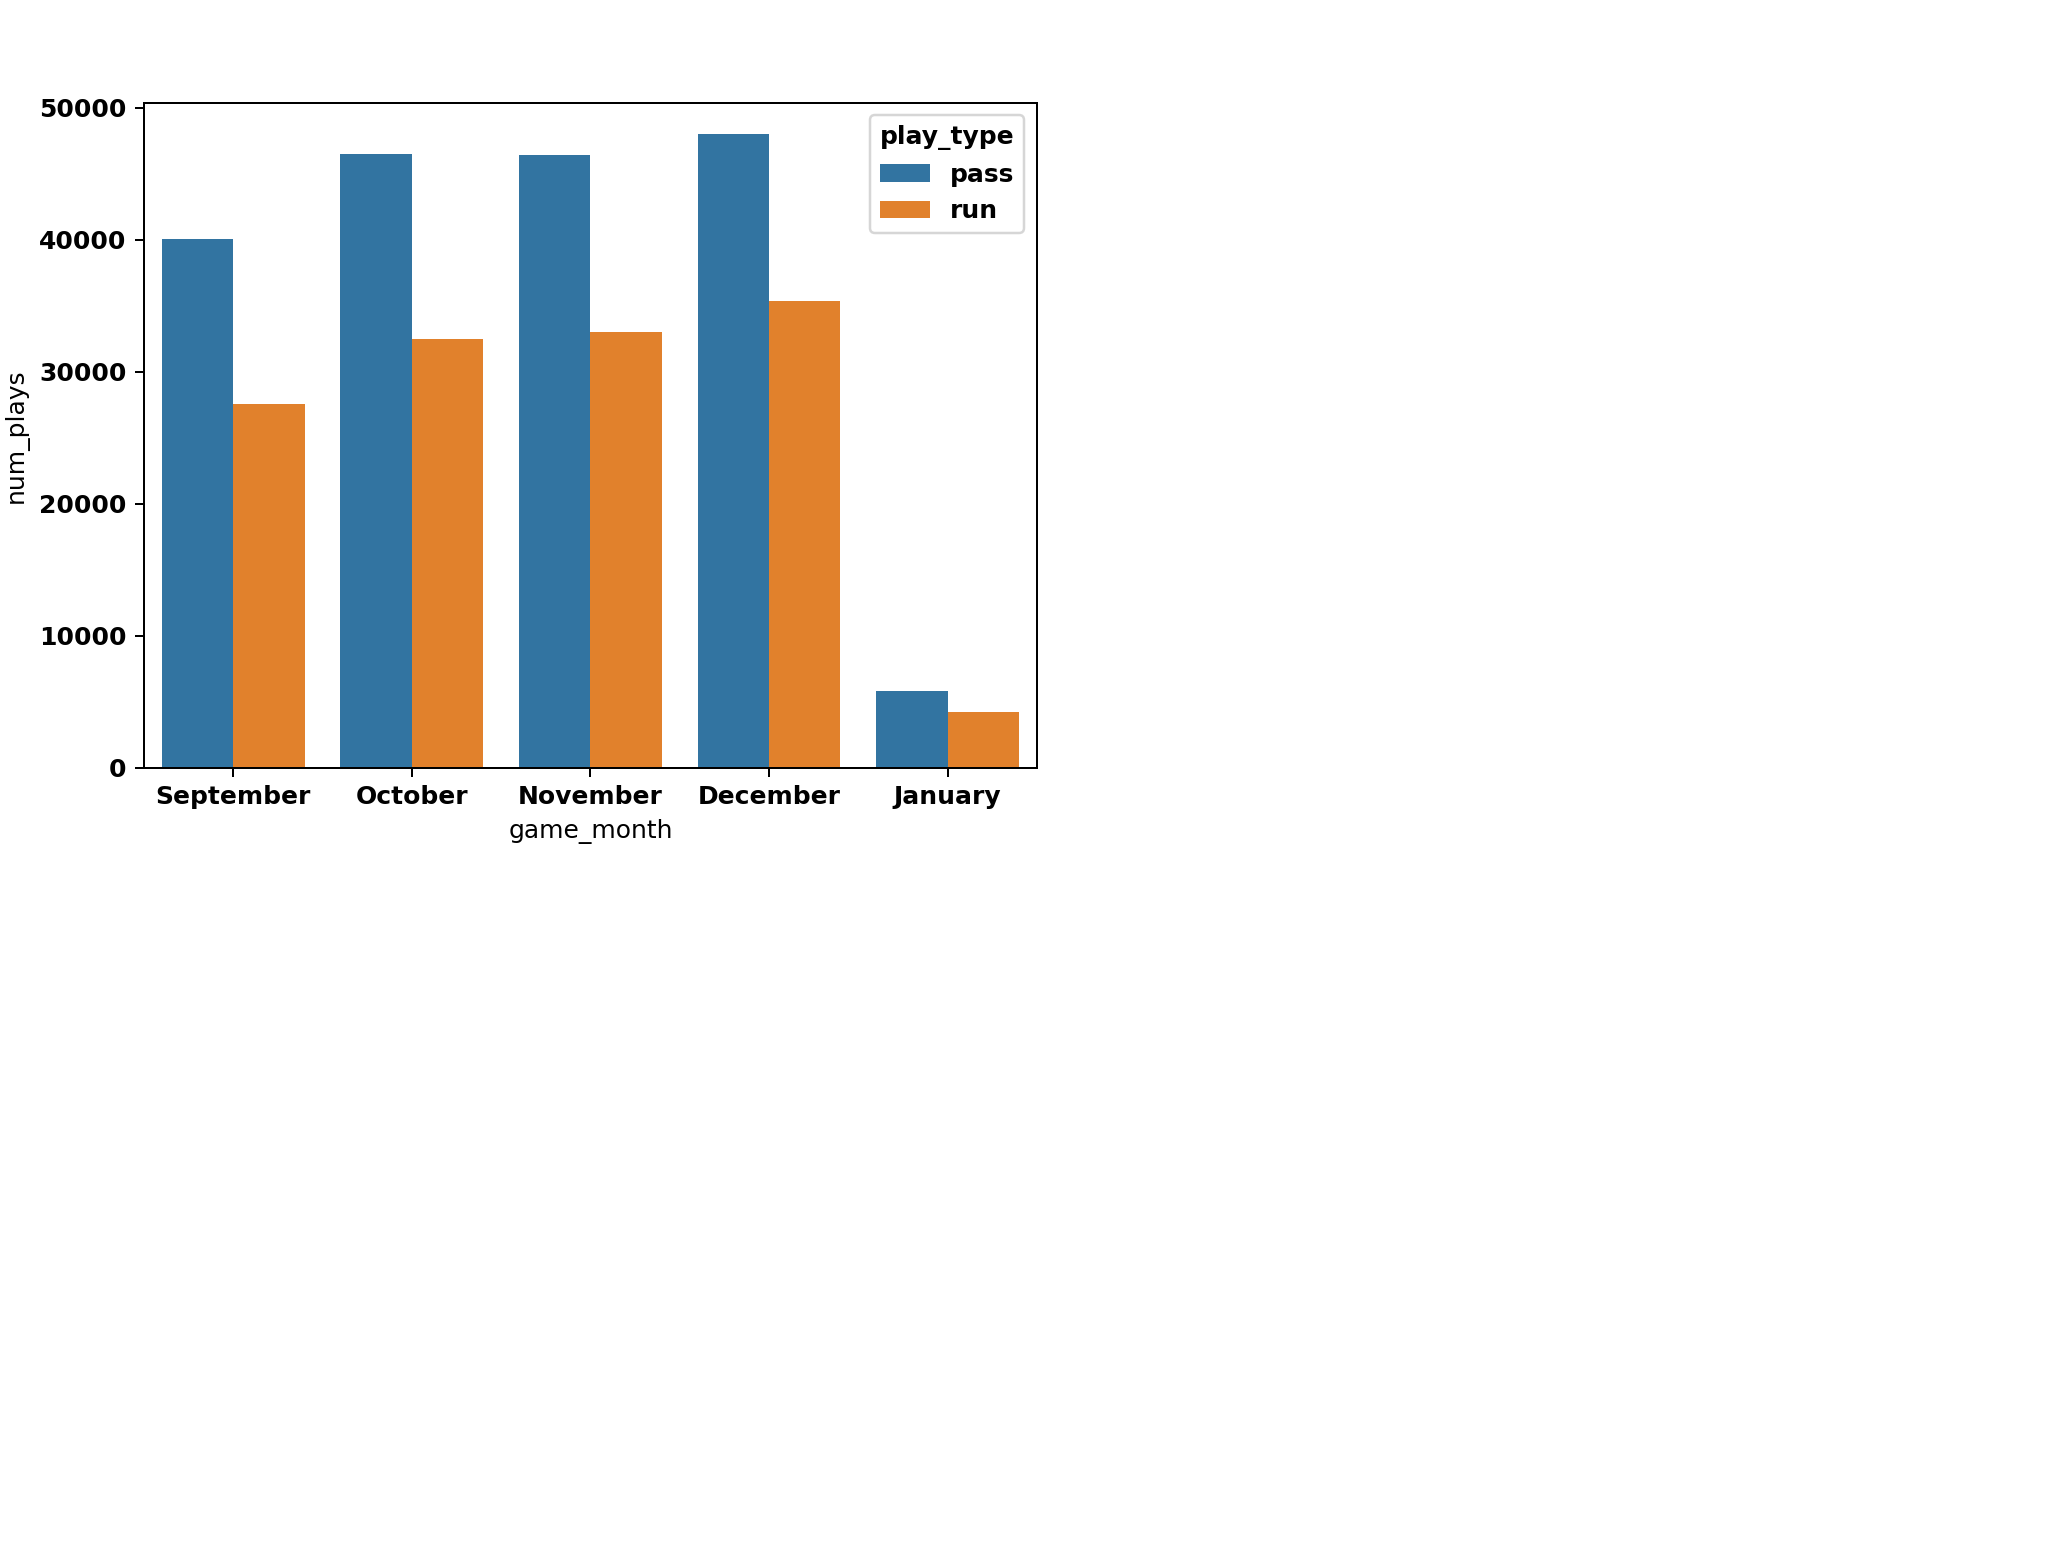

In [55]:
sns.barplot(data=play_types_by_month.reset_index(), x='game_month', y='num_plays', hue='play_type', order=df.game_month.unique());
plt.show()

In [56]:
df[df['play_type'].isin(['pass', 'run'])].groupby(['game_month', 'play_type']).size()

game_month  play_type
December    pass         47974
            run          35383
January     pass          5794
            run           4258
November    pass         46420
            run          32998
October     pass         46457
            run          32503
September   pass         40032
            run          27550
dtype: int64

In [57]:
df[df['play_type'].isin(['pass', 'run'])].groupby(['game_month'])['game_id'].nunique()

game_month
December     666
January       80
November     619
October      624
September    537
Name: game_id, dtype: int64

In [58]:
df[df['play_type'].isin(['pass', 'run'])].groupby(['game_month', 'play_type']).size()/df[df['play_type'].isin(['pass', 'run'])].groupby(['game_month'])['game_id'].nunique()

game_month  play_type
December    pass         72.033033
            run          53.127628
January     pass         72.425000
            run          53.225000
November    pass         74.991922
            run          53.308562
October     pass         74.450321
            run          52.088141
September   pass         74.547486
            run          51.303538
dtype: float64

In [59]:
plays_per_game_by_month_and_season = (df[df['play_type'].isin(['pass', 'run'])].groupby(['season', 'game_month', 'play_type']).size()/df.groupby(['season', 'game_month'])['game_id'].nunique()/2).to_frame("num_plays")

<IPython.core.display.Javascript object>


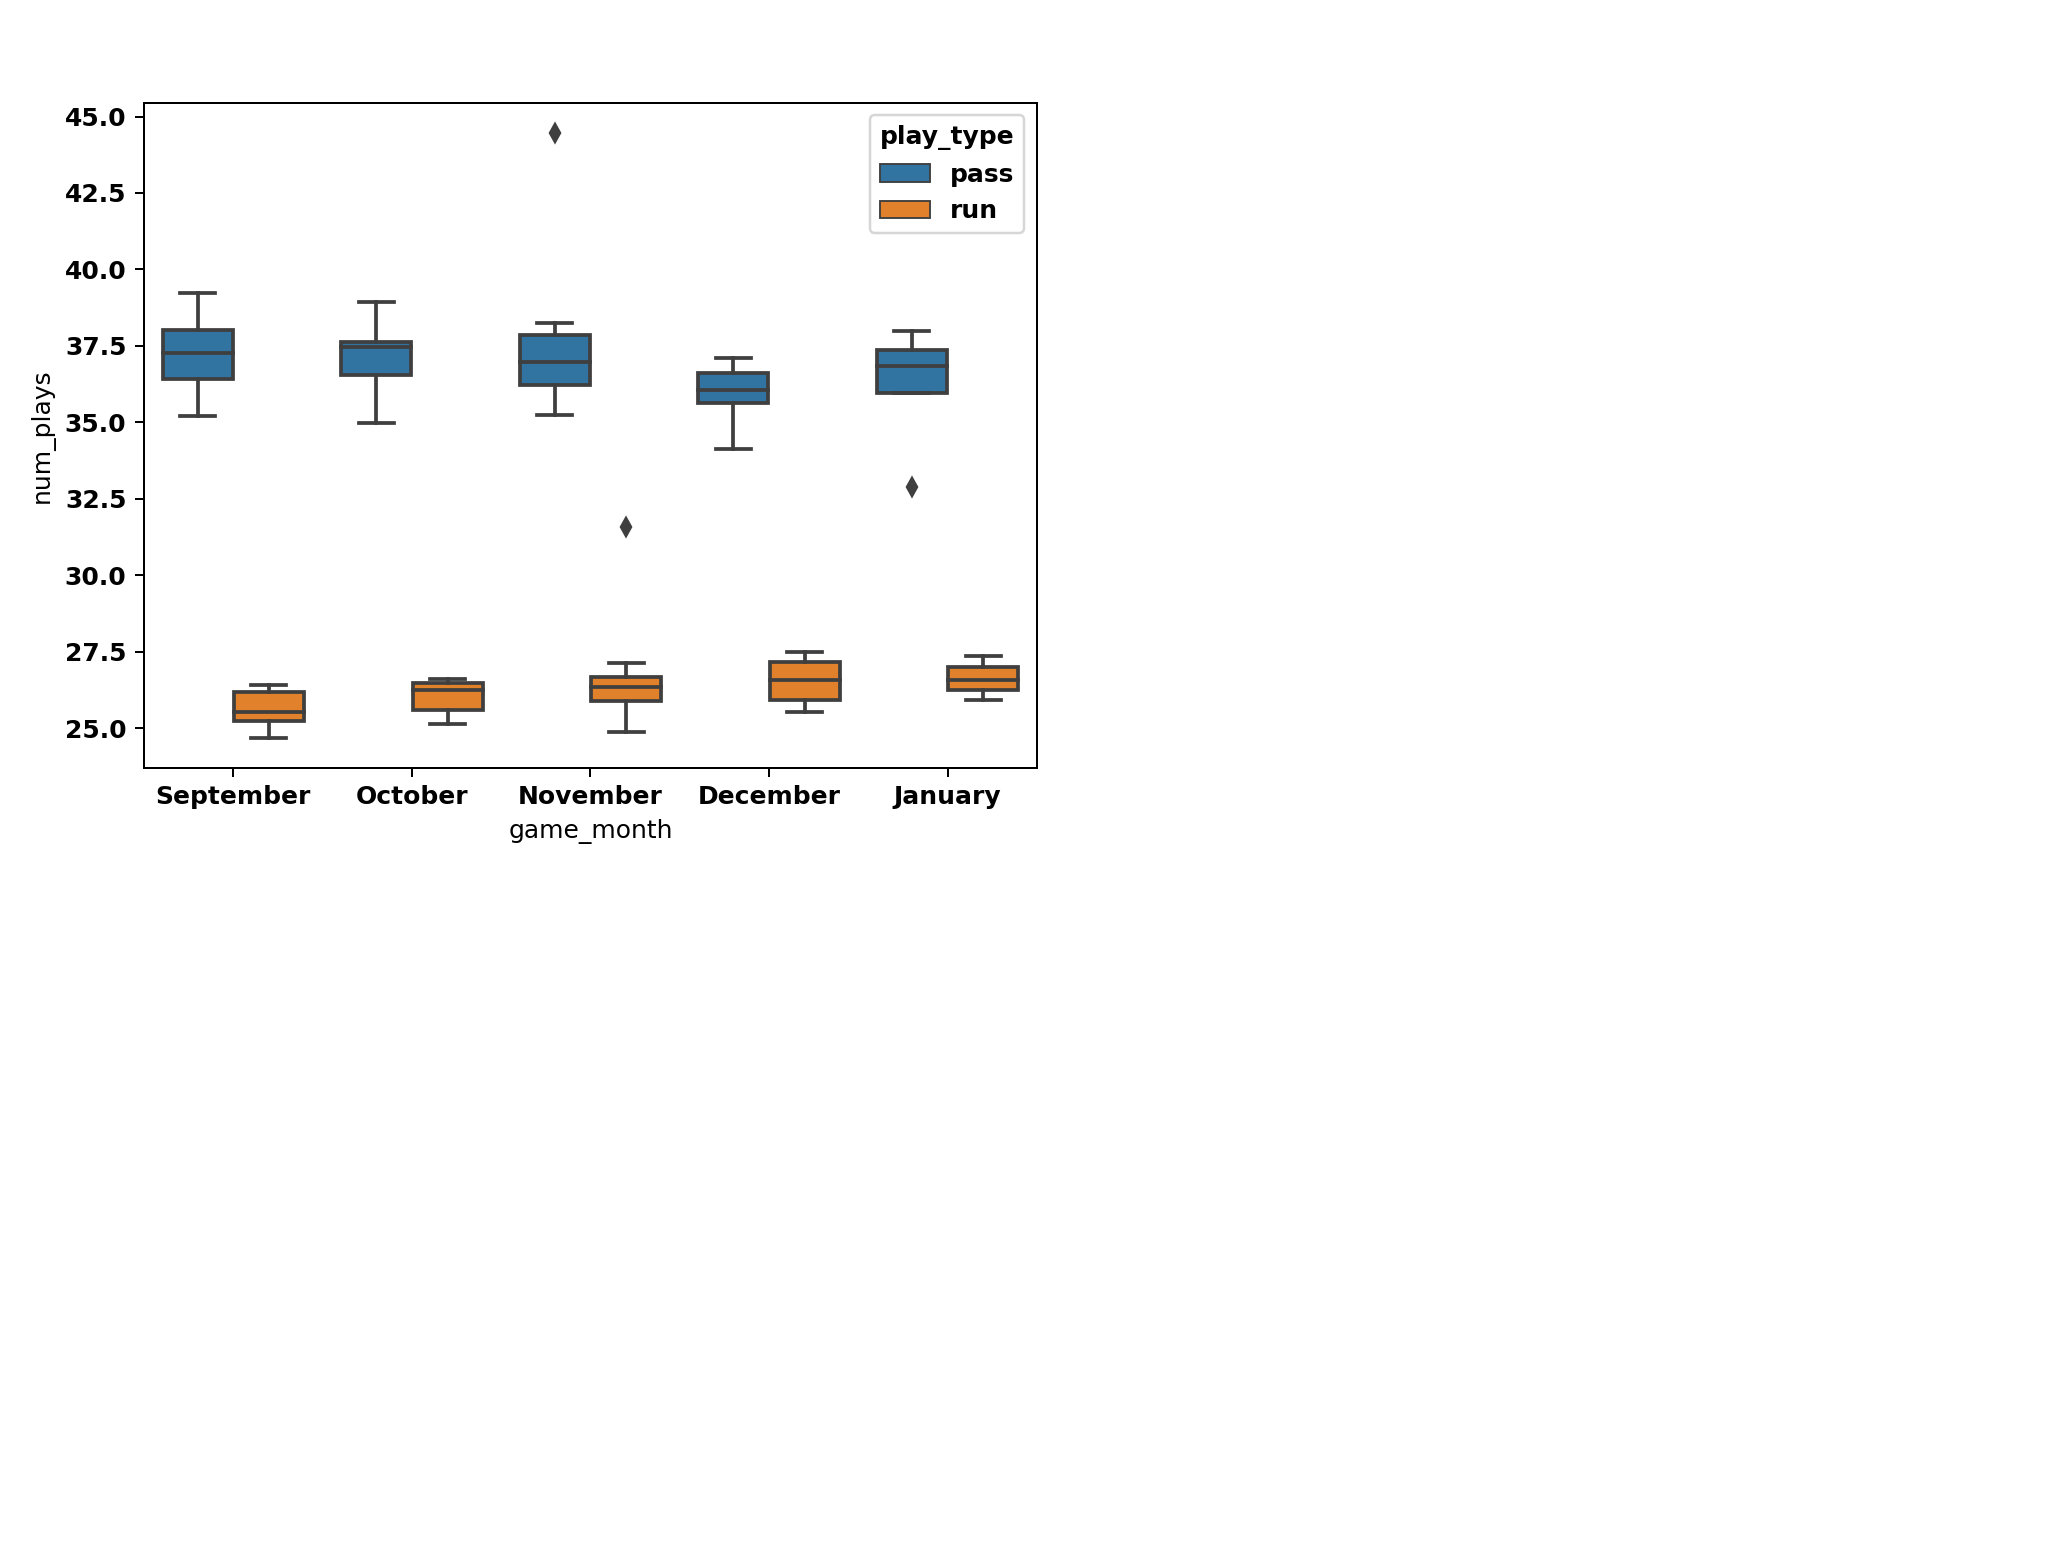

In [60]:
sns.boxplot(data=plays_per_game_by_month_and_season.reset_index(), x='game_month', y='num_plays', hue='play_type', order=df.game_month.unique());
plt.show()

<IPython.core.display.Javascript object>


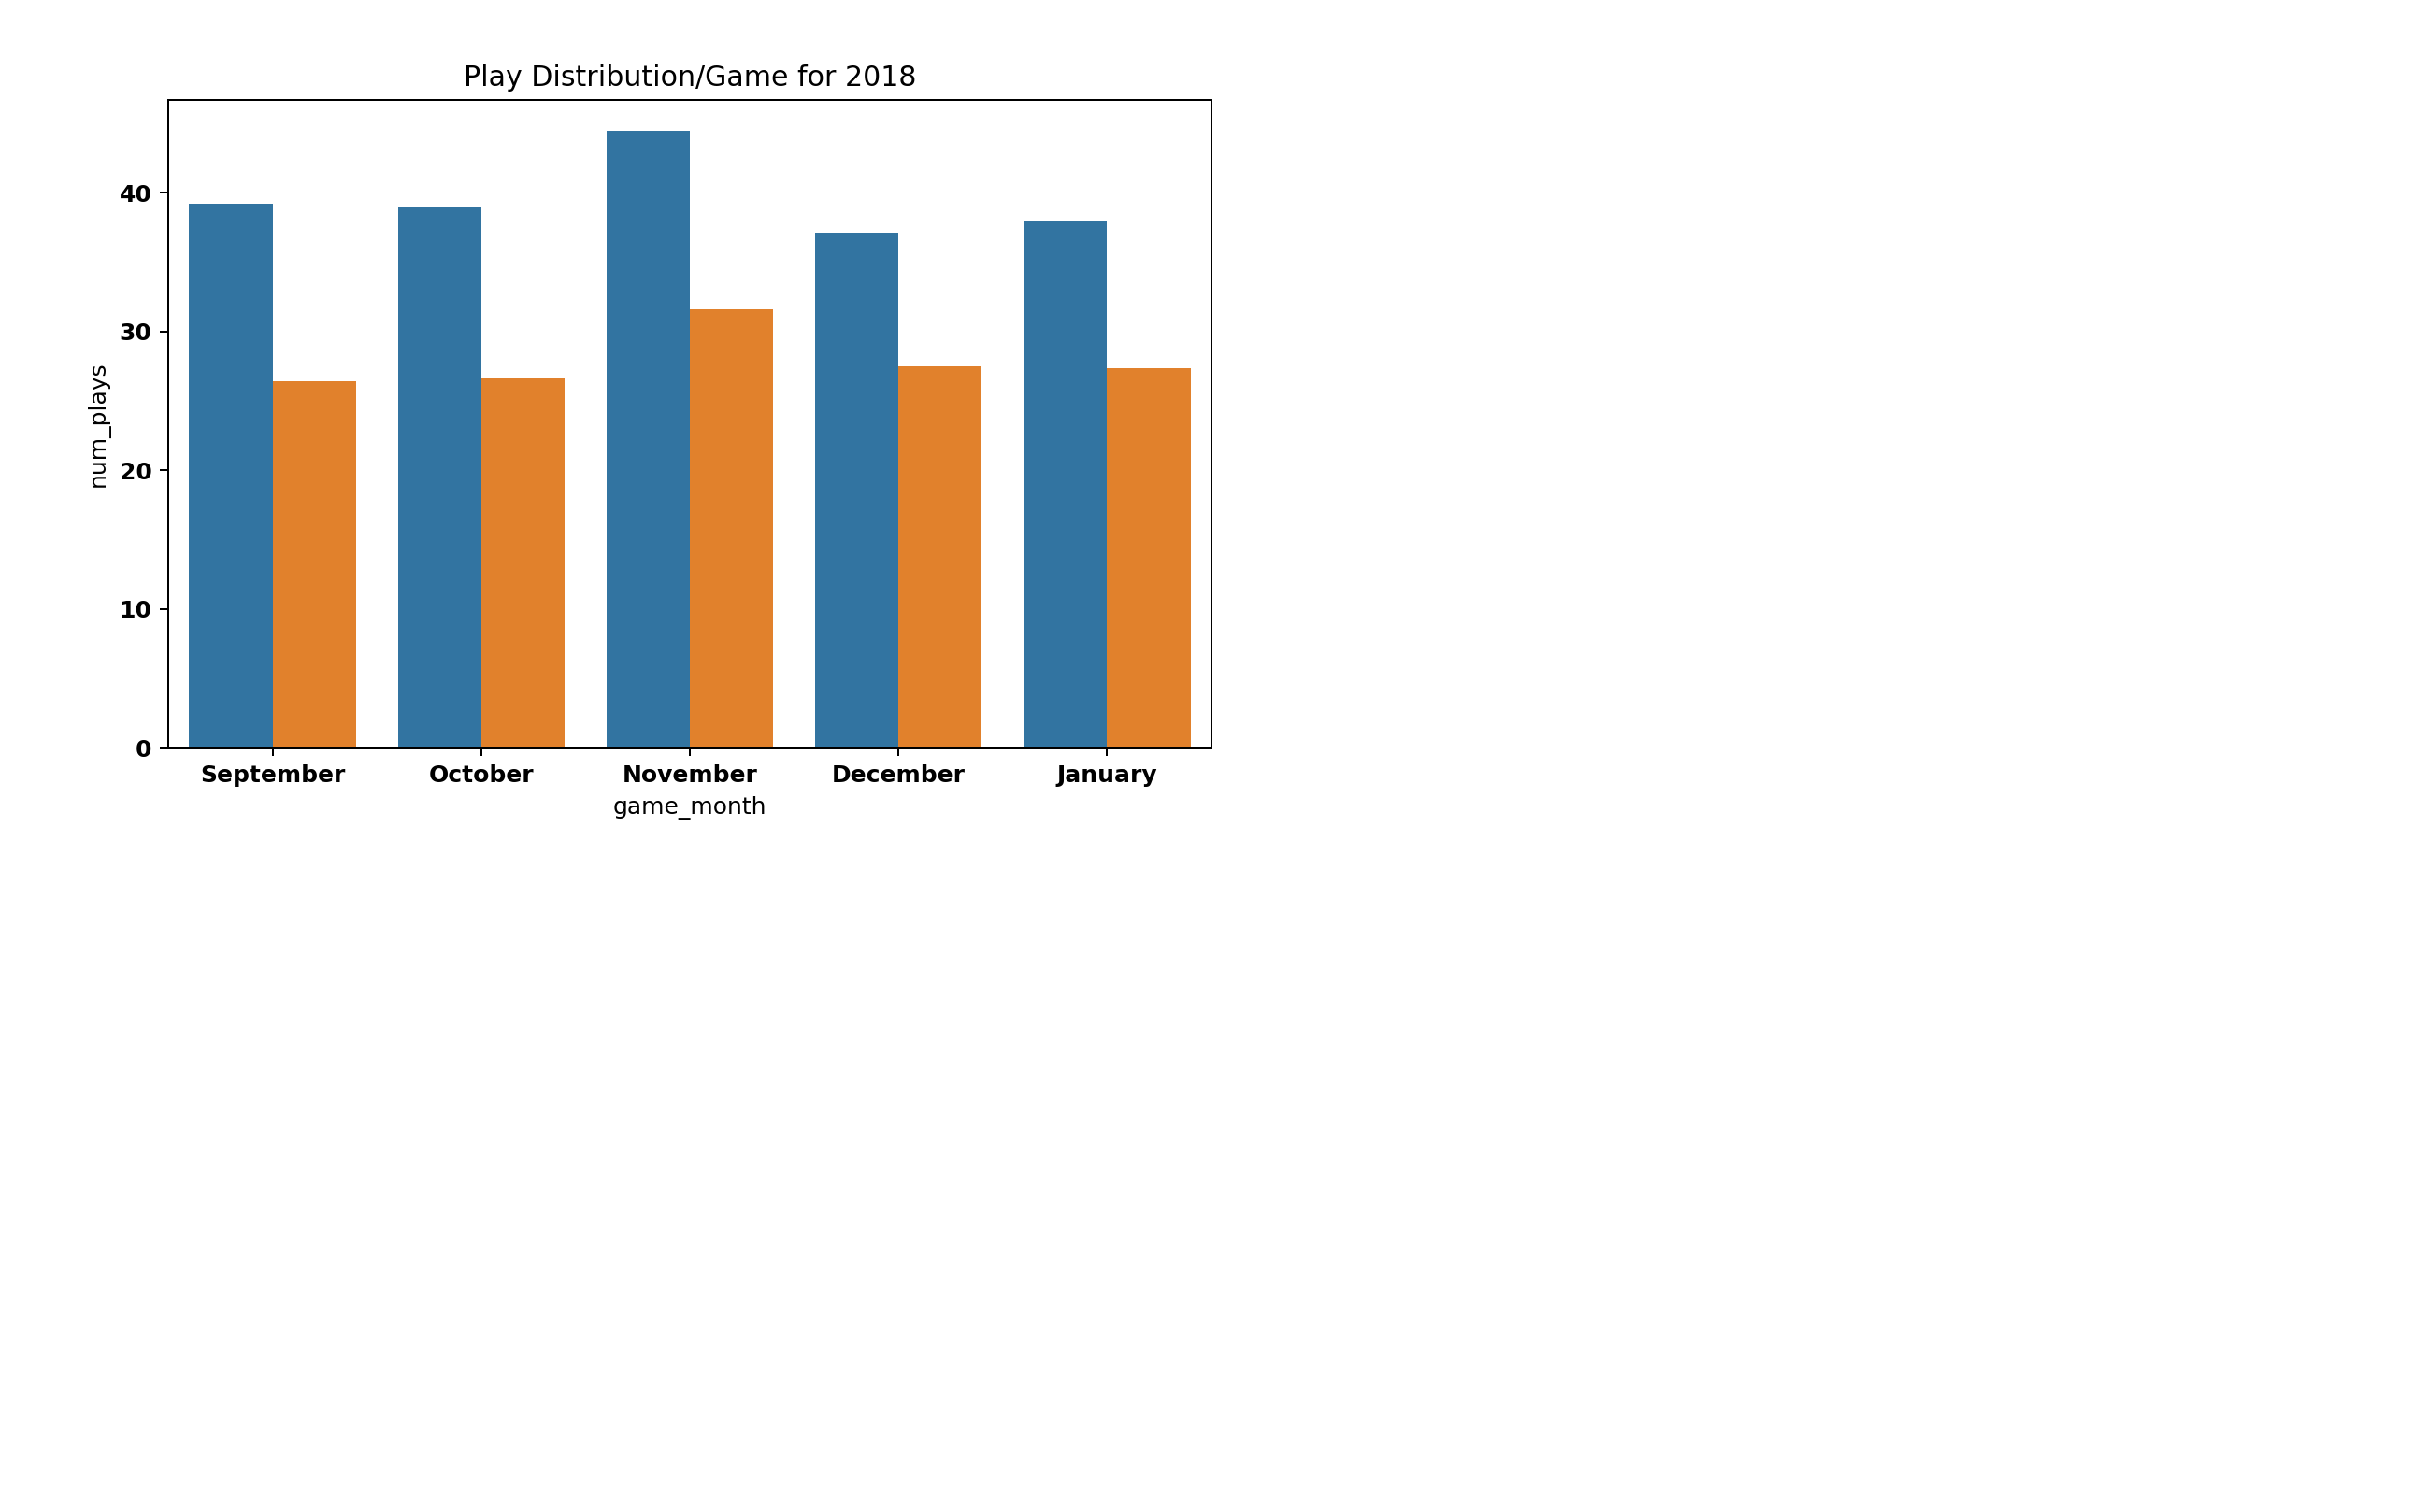

In [69]:
fig, ax = plt.subplots(figsize=(8,5))
for season in range(2009, 2019):
    sns.barplot(data=plays_per_game_by_month_and_season.loc[season].reset_index(), x='game_month', y='num_plays', hue='play_type', order=df.game_month.unique(), ax=ax)
    ax.set_title(f"Play Distribution/Game for {season}")
    ax.get_legend().remove()
    plt.show()
    fig.canvas.draw()
    sleep(0.5)

In [377]:
df[df['play_type'].isin(['pass', 'run'])].groupby(['game_month', 'season', 'play_type']).size()

game_month  season  play_type
December    2009    pass         4496
                    run          3517
            2010    pass         4370
                    run          3489
            2011    pass         4544
                                 ... 
September   2016    run          2468
            2017    pass         3482
                    run          2422
            2018    pass         4805
                    run          3061
Length: 90, dtype: int64

In [380]:
df.groupby(['game_month', 'season'])['game_id'].nunique()

game_month  season
December    2009      64
            2010      64
            2011      64
            2012      79
            2013      77
            2014      65
            2015      64
            2016      63
            2017      79
            2018      47
January     2009      16
            2010      16
            2011      16
            2015      16
            2016      16
November    2009      73
            2010      60
            2011      60
            2012      59
            2013      58
            2014      69
            2015      70
            2016      56
            2017      58
            2018      56
October     2009      55
            2010      68
            2011      68
            2012      55
            2013      58
            2014      61
            2015      58
            2016      71
            2017      71
            2018      59
September   2009      48
            2010      48
            2011      48
            2012      62
      

game_month  season
December    2009      64
            2010      64
            2011      64
            2012      79
            2013      77
            2014      65
            2015      64
            2016      63
            2017      79
            2018      47
January     2009      16
            2010      16
            2011      16
            2015      16
            2016      16
November    2009      73
            2010      60
            2011      60
            2012      59
            2013      58
            2014      69
            2015      70
            2016      56
            2017      58
            2018      56
October     2009      55
            2010      68
            2011      68
            2012      55
            2013      58
            2014      61
            2015      58
            2016      71
            2017      71
            2018      59
September   2009      48
            2010      48
            2011      48
            2012      62
      